# To do:
See if 4square menu is anything

Parse the Locu menus

In [37]:
import requests
import os
import importlib
import pandas as pd
import numpy as np
%matplotlib inline
import pdb
import json
import time
import Kibbeh.src.feature_calc as feature_calc
import Kibbeh.src.API_io as API_io

In [2]:
working_dir = 'C:\\Users\\Chauncey\\Documents\\GitHub\\Kibbeh'
#working_dir = 'C:\\Users\\Me\\Documents\\GitHub\\Kibbeh'
seattle_zips = pd.read_csv(working_dir + '\\seattle_zips.csv')['Zip'].values

# Load Yelp data

In [21]:
# load
with open('yelp_restaurant_list.json', 'r') as json_file:
    yelp_restos = json.load( json_file)

In [ ]:
from yelpapi import YelpAPI
with open(working_dir+ '\\yelp_api_key.txt', 'r') as api_file:
    api_key =  api_file.read()
    [CONSUMER_KEY, CONSUMER_SECRET, TOKEN, TOKEN_SECRET] = api_key.split('\n')

In [ ]:
yelp_api = YelpAPI(CONSUMER_KEY, CONSUMER_SECRET, TOKEN, TOKEN_SECRET)

In [ ]:
def get_restaurants_yelp():
    restaurant_data = []
    for cur_offset in range(0, 1000, 20):
        # sort = 0 sets by default, limited to 1000, sort = 2 is ranked from best to worst, but limited to 40
        cur_query = yelp_api.search_query(term='food', location = 'Seattle', sort=0, limit=20, offset = cur_offset) 
        #pdb.set_trace()
        restaurant_data.extend( cur_query['businesses'])
    return restaurant_data

In [ ]:
yelp_restos = get_restaurants_yelp()
len(yelp_restos)

In [ ]:
# save
with open('yelp_restaurant_list.json', 'w') as json_file:
    json.dump(yelp_restos, json_file)

# Load Foursquare data

In [3]:
# load save data
with open('foursquare_restaurant_list.json', 'r') as json_file:
    fs_top_restos = json.load( json_file)

In [31]:
import foursquare
with open(working_dir+ '\\foursquare_api_key.txt', 'r') as api_file:
    api_key =  api_file.read()
    [FOURSQUARE_ID, FOURSQUARE_SECRET] = api_key.split('\n')
foursquare_client = foursquare.Foursquare(FOURSQUARE_ID, FOURSQUARE_SECRET)

In [35]:
# get data from all seattle zip codes
fs_top_restos = API_io.get_top_restos_zip_4square(foursquare_client, seattle_zips[:2])
# this takes a while to run

98001
98002


In [368]:
# save
with open('fs_restaurant_list.json', 'w') as json_file:
    json.dump(fs_top_restos, json_file)

In [319]:
seattle_grid = [-122.38, -122.28, 47.55, 47.70]
def get_restos_by_ll_4square(grid_values):
    ''' get restaurants by latitude and longitude
        restaurants returned by this almost all do not have ratings
        '''
    restaurant_data = []
    query_limit = 50
    
    # set up longitude latitude grid
    grid_step = 0.01
    x_range = np.arange(grid_values[0], grid_values[1], grid_step)
    y_range = np.arange(grid_values[2], grid_values[3], grid_step)
    grid_radius= 250 # in meters
    
    for x in x_range:
        for y in y_range:
            #pdb.set_trace
            string_ll = str(y) + ',' +str(x)
            grid_params = {'ll': string_ll, 'categoryId': '4d4b7105d754a06374d81259',
                                                      'radius': grid_radius, 'limit': query_limit}
            cur_query = foursquare_client.venues.search(params=grid_params)
            #pdb.set_trace()
            restaurant_data.extend(cur_query['venues'])
            time.sleep(0.5)
    return restaurant_data

fs_ll_restos = get_restos_by_ll_4square(seattle_grid)

# Load OpenMenu data
Denied on OpenMenu API request

# Load Locu data
### Set up api key and class

In [13]:
from Kibbeh.src.locu_api import VenueApiClient, MenuItemApiClient

In [25]:
working_dir = 'C:\\Users\\Chauncey\\Documents\\GitHub\\Kibbeh'
#working_dir = 'C:\\Users\\Me\\Documents\\GitHub\\Kibbeh'
with open(working_dir+ '\\locu_api_key.txt', 'r') as api_file:
    api_key =  api_file.read()
    [LOCU_KEY] = api_key.split('\n')

In [14]:
venue_client = VenueApiClient(LOCU_KEY)

### Get list of locu restaurants by zip code

In [ ]:
# load
with open('locu_restaurant_list.json', 'r') as json_file:
    locu_restos = json.load( json_file)

In [70]:
import itertools
def get_locu_by_zip(venue_client, zip_list):
    # a set of 25 restaurants with menus for each zip code in seattle
    list_of_lists =  list(map(lambda x: venue_client.search(category=['restaurant'], has_menu=True, postal_code=x)['objects'],
                              zip_list) )
    return list(itertools.chain(*list_of_lists))

#venues = venue_client.search(locality = 'Seattle', has_menu=True)

In [74]:
locu_restos = get_locu_by_zip(venue_client, seattle_zips)
len(locu_restos)

1277

In [76]:
# save
with open('locu_restaurant_list.json', 'w') as json_file:
    json.dump(locu_restos, json_file)

### Search for menus of locations from yelp
To get yelp_df, need to execute feature_extraction below

In [377]:
import time
def get_menus_yelp(yelp_df, locu_restos, venue_client):
    ''' yelp_df is a dataframe with the 'name' as the index
        locu_restos is a json list of locu restaurant metadat '''
    
    new_locu_list = []
    menu_list = []
    
    # use phone number as unique index
    locu_phones = [x['phone'] for x in locu_restos ]
    locu_phones = list(map( lambda x: re.sub('[()\- ]', '',str(x)),  locu_phones) ) # get rid of punctuation
    
    # find menus for everything in yelp df
    for cur_resto in yelp_df.iterrows():
        try:
            # cur_resto[0] is the index / name, cur_resto[1] is the data
            if cur_resto[1]['phone'] in locu_phones:    # check if I have locu id for this restaurant
                cur_locu_id = locu_restos[ locu_phones.index(cur_resto[1]['phone']) ]['id']
                cur_menu = venue_client.get_menus(cur_locu_id)
            else:
                cur_locu = venue_client.search(name = cur_resto[0], locality='Seattle', category=['restaurant'], has_menu=True)
                time.sleep(1)
                if cur_locu['objects'] == []: # can't get a menu for this restaurant
                    continue
                new_locu_list.append(cur_locu['objects'][0])

                cur_menu = venue_client.get_menus( cur_locu['objects'][0]['id'] )

            menu_list.append( [cur_resto[0], cur_menu ] )
            time.sleep(2)
            #if cur_name
        except:
            print('Reached rate limit on restaurant: {0}'.format(cur_resto[0]))
            break
    return menu_list, new_locu_list

In [378]:
locu_yelp_overlap_menus = get_menus_yelp(yelp_df[:200], locu_restos, venue_client)

Reached rate limit on restaurant: Piroshky Piroshky


In [ ]:
locu_yelp_overlap_menus

In [181]:
len(locu_yelp_overlap_menus[0])

13

# Feature extraction
## Yelp

In [42]:
importlib.reload(feature_calc)
yelp_df = feature_calc.feature_extract_yelp_list(yelp_restos)
yelp_df.head(3)

,categories,id,phone,rating,review_count
name,,,,,
Piroshky Piroshky,"[Bakeries, Russian]",piroshky-piroshky-seattle,2064416068,4.5,3235
Paseo,"[Caribbean, Cuban, Sandwiches]",paseo-seattle-3,2065457440,4.5,4099
Umma's Lunch Box,"[Korean, Buffets]",ummas-lunch-box-seattle,2068543166,4.5,184


In [83]:
yelp_df.shape

(1000, 5)

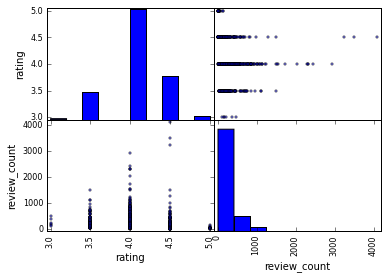

In [12]:
pd.scatter_matrix(ganma);

In [ ]:
yelp_api.business_query(restaurant_json[20]['id'])

## Foursquare feature extraction

In [4]:
fs_rated = [x for x in fs_top_restos if 'rating' in x['venue'].keys()]
len(fs_rated)

7021

In [43]:
importlib.reload(feature_calc)
fs_dict = feature_calc.feature_extract_fs_list(fs_rated)
fs_dict.head(3)

,categories,checkinsCount,id,phone,rating,tier,tipCount,usersCount
name,,,,,,,,
Burger Express,Burgers,629,4c0c1f2d6071a593a954e232,2538742701,8.8,1,13,320
Señor Taco,Burritos,391,4b6a5e42f964a520a4d32be3,2536619915,8.7,1,12,138
Popeyes Louisiana Kitchen,Fried Chicken,470,4aeb5ad8f964a52050c121e3,2538749740,8.1,1,8,287


In [44]:
fs_dict['phone'][0]

'2538742701'